# Make things Ready

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

# shared path to drive
SHARED_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

# direct path to drive
DIRECT_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Mounted at /content/drive


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = (
    SHARED_PATH
    if os.path.exists(SHARED_PATH)
    else DIRECT_PATH
    if os.path.exists(DIRECT_PATH)
    else None
)

DATA_PATH = ""
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
validate_images
training_images
ALL_IMG_DATA
no_side_one_output_classify
ALL_IMG_DATA.csv
make_train-test-split_from_all_img_data.ipynb
expr2_resnet18_two_output_(sides classify).ipynb
RUN_THIS_all_in_1_changable_parameter_(2_output).ipynb


##  Setup Device & Random State

In [ ]:
import torch
import random
import numpy as np

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# define the random seed
SEED = 2025


torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.Generator().manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

cuda


## Load data(csv) & Train-Test Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display

# Load the CSV data into a DataFrame
df = pd.read_csv(DATA_PATH + "/ALL_IMG_DATA.csv")
display(df.head())
#  --- Derive ALL unique categories from the FULL DataFrame ---
BUILDING_CATEGORIES = sorted(df["class"].unique().tolist())
FACADE_CATEGORIES = sorted(df["subclass"].unique().tolist())

print("\nMaster Building Categories:", BUILDING_CATEGORIES)
print("Master Facade Categories:", FACADE_CATEGORIES)

,path,class,subclass
0,/ALL_IMG_DATA/gurudeb_front/gurudeb_005.jpeg,gurudeb,front
1,/ALL_IMG_DATA/gurudeb_front/gurudeb_004.jpeg,gurudeb,front
2,/ALL_IMG_DATA/gurudeb_front/frame_0210.jpg,gurudeb,front
3,/ALL_IMG_DATA/gurudeb_front/gurudeb_002.jpeg,gurudeb,front
4,/ALL_IMG_DATA/gurudeb_front/gurufront_00040.jpeg,gurudeb,front



Master Building Categories: ['admin', 'chemistry', 'gurudeb', 'heritage']
Master Facade Categories: ['front', 'left', 'right']


In [ ]:
# Split the data into training and testing sets

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['class'])
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["subclass"]
)
# this distrubutes better
print(
    "------------ Training set subclass frequencies within each class ----------------"
)
print(train_df.groupby("class")["subclass"].value_counts().sort_index())
print("------------ Test set subclass frequencies within each class ----------------")
print(test_df.groupby("class")["subclass"].value_counts().sort_index())

------------ Training set subclass frequencies within each class ----------------
class      subclass
admin      front       27
           left        21
           right       25
chemistry  front       32
           left        28
           right       28
gurudeb    front       33
           left        22
           right       26
heritage   front       27
           left        26
Name: count, dtype: int64
------------ Test set subclass frequencies within each class ----------------
class      subclass
admin      front       7
           left        6
           right       7
chemistry  front       8
           left        7
           right       9
gurudeb    front       8
           left        5
           right       4
heritage   front       7
           left        6
Name: count, dtype: int64


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
standev = [0.229, 0.224, 0.225]
px = 256

train_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(10),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomHorizontalFlip(), #!! it will change left right
        transforms.ColorJitter(),
        # transforms.RandomAffine(degrees=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


class MakeTorchDataset(Dataset):
    def __init__(
        self,
        dataframe,
        image_base_path=DATA_PATH,
        building_categories=BUILDING_CATEGORIES,
        facade_categories=FACADE_CATEGORIES,
        transform=None,
    ):
        self.dataframe = dataframe
        self.image_base_path = image_base_path
        self.transform = transform
        # Create mappings for class and subclass based on the *provided* category lists
        self.class_to_idx = {
            cls_name: i for i, cls_name in enumerate(building_categories)
        }
        self.subclass_to_idx = {
            sub_name: i for i, sub_name in enumerate(facade_categories)
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_full_path = self.image_base_path + self.dataframe.iloc[idx]["path"]
        # print(img_full_path)
        image = Image.open(img_full_path).convert("RGB")

        # Access labels by column name for clarity and robustness
        building_class_name = self.dataframe.iloc[idx]["class"]
        facade_subclass_name = self.dataframe.iloc[idx]["subclass"]

        # Convert string labels to integer indices using the pre-defined mappings
        building_class_label = self.class_to_idx[building_class_name]
        facade_subclass_label = self.subclass_to_idx[facade_subclass_name]

        if self.transform:
            image = self.transform(image)  # apply transformation

        return image, building_class_label, facade_subclass_label

In [8]:
train_dataset = MakeTorchDataset(dataframe=train_df, transform=train_transform)
test_dataset = MakeTorchDataset(dataframe=test_df, transform=test_transform)

print("Building Categories:", train_dataset.class_to_idx)
print("Facade Categories:", train_dataset.subclass_to_idx)

train_dataset.__getitem__(0)

Building Categories: {'admin': 0, 'chemistry': 1, 'gurudeb': 2, 'heritage': 3}
Facade Categories: {'front': 0, 'left': 1, 'right': 2}


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -0.3369, -0.0629,  0.0398],
          [-2.1179, -2.1179, -2.1179,  ..., -0.6623, -0.9877, -1.1760],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5253, -0.2856, -0.1314],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.8618,  0.8618,  0.9132],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -0.1275,  0.1877,  0.2927],
          [-2.0357, -2.0357, -2.0357,  ..., -0.4601, -0.7577, -0.9503],
          [-2.0357, -2.0357, -2.0357,  ..., -0.2850, -0.0574,  0.1001],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.1099, -0.1275, -0.1450],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -0.0267,  0.2871,  0.3916],
          [-1.8044, -1.8044,

## Class definition

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


class BuildingWithFacadeClassifier:
    """
    A class for training, evaluating, and classifying images with a multi-head model
    using a custom dataset that directly provides two labels.
    """

    def __init__(
        self,
        model,
        optimizer,
        batch_size=16,
        building_categories=BUILDING_CATEGORIES,
        facade_categories=FACADE_CATEGORIES,
        building_loss_fn=nn.CrossEntropyLoss(),
        facade_loss_fn=nn.CrossEntropyLoss(),
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        device=DEVICE,
    ):
        self.model = model.to(device)
        self.building_loss_fn = building_loss_fn
        self.facade_loss_fn = facade_loss_fn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.building_categories = building_categories
        self.facade_categories = facade_categories
        self.device = device

        self.learning_rate = self.optimizer.param_groups[0]["lr"]
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )  # , num_workers=2)
        self.test_loader = DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False
        )  # , num_workers=2)

    ###############################################################################################
    # Train the model for a specified number of epochs...........................................
    def train(self, n_epochs=10, output_logging=True):
        # Store individual lists for plotting later if needed
        loss_graph_list, valid_loss_list = [], []
        building_accy_list, facade_accy_list = [], []

        print(
            f"Starting training with Learning Rate: {self.learning_rate}, Batch Size: {self.batch_size}, Epochs: {n_epochs}, Device: {self.device}----"
        )

        for epoch in tqdm(range(n_epochs)):
            self.model.train()  # set model to training mode each time
            training_loss = []

            for i_image, i_building_label, i_facade_label in self.train_loader:
                i_image = i_image.to(self.device)
                i_building_label = i_building_label.to(self.device)
                i_facade_label = i_facade_label.to(self.device)

                self.optimizer.zero_grad()
                output_building, output_facade = self.model(i_image)

                # Calculate loss for each head
                loss_building = self.building_loss_fn(output_building, i_building_label)
                # Ensure retain_graph=True if building_loss_fn's backward pass needs to keep graph for facade_loss_fn's backward
                # loss_building.backward()
                loss_building.backward(retain_graph=True)  # Need retain_graph=True
                # If they are independent, or if you sum before backward, it might not be needed.
                # A common pattern is to sum losses and then backward once.

                loss_facade = self.facade_loss_fn(output_facade, i_facade_label)
                loss_facade.backward()  # No retain_graph=True needed here

                # Combine losses (e.g., simple average or weighted average)
                # Summing before backward is generally more efficient than two separate backward calls with retain_graph
                total_loss = (loss_building + loss_facade) / 2
                # total_loss.backward()

                self.optimizer.step()

                training_loss.append(total_loss.item())  # Use total_loss here

            mean_training_loss = np.mean(training_loss)
            loss_graph_list.append(mean_training_loss)

            # Call evaluate and get both accuracies and validation loss
            building_accy, facade_accy, current_valid_loss = self.evaluate(
                output_logging=False
            )  # Set output_logging to False

            valid_loss_list.append(current_valid_loss)
            building_accy_list.append(building_accy)
            facade_accy_list.append(facade_accy)

            if output_logging:
                print(
                    f" Training loss: {mean_training_loss:.4f} --Validation Loss: {current_valid_loss:.4f} --Building Accuracy: {building_accy:.2f}% --Facade Accuracy: {facade_accy:.2f}%"
                )

        print("Training done.....................")
        # return detailed logs to plot them later
        return {
            "train_loss": loss_graph_list,
            "val_loss": valid_loss_list,
            "building_accy": building_accy_list,
            "facade_accy": facade_accy_list,
        }

    ###############################################################################################
    # Evaluate the model on the test set (ENHANCED for both tasks)..............................
    def evaluate(self, output_logging=True, disp_confusion_matrix=False):
        self.model.eval()  # set model to evaluation mode
        # Lists to store actual and predicted labels for confusion matrices
        actual_building_labels = []
        predicted_building_labels = []
        actual_facade_labels = []
        predicted_facade_labels = []
        validation_loss = []

        with torch.no_grad():
            for i_image, i_building_label, i_facade_label in self.test_loader:
                i_image = i_image.to(self.device)
                i_building_label = i_building_label.to(self.device)
                i_facade_label = i_facade_label.to(self.device)

                output_building, output_facade = self.model(i_image)

                loss_building = self.building_loss_fn(output_building, i_building_label)
                loss_facade = self.facade_loss_fn(output_facade, i_facade_label)
                total_loss = (loss_building + loss_facade) / 2
                validation_loss.append(total_loss.item())

                # Get predictions for building task
                _, predicted_building = torch.max(output_building.data, 1)
                actual_building_labels.extend(i_building_label.cpu().numpy())
                predicted_building_labels.extend(predicted_building.cpu().numpy())

                # Get predictions for facade task
                _, predicted_facade = torch.max(output_facade.data, 1)
                actual_facade_labels.extend(i_facade_label.cpu().numpy())
                predicted_facade_labels.extend(predicted_facade.cpu().numpy())

        # Calculate accuracies for each task
        building_accuracy = (
            accuracy_score(actual_building_labels, predicted_building_labels) * 100.0
        )
        facade_accuracy = (
            accuracy_score(actual_facade_labels, predicted_facade_labels) * 100.0
        )

        average_validation_loss = np.mean(validation_loss)

        if output_logging:
            print(f" --Validation Loss: {average_validation_loss:.4f}", end="")
            print(f"  --Building Accuracy: {building_accuracy:.2f}%", end="")
            print(f"  --Facade Accuracy: {facade_accuracy:.2f}%")

        if disp_confusion_matrix:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
            # Confusion Matrix for Building Classification on the first subplot (ax1)
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(
                    actual_building_labels, predicted_building_labels
                ),
                display_labels=[
                    str(label) for label in self.building_categories
                ],  # Use defined building categories
            ).plot(cmap="Blues", ax=ax1)  # Specify ax=ax1 to plot on the first subplot
            ax1.tick_params(
                axis="x", rotation=90
            )  # Rotate x-axis labels for readability on ax1
            ax1.set_title("Building Classification")

            # Confusion Matrix for Facade Classification on the second subplot (ax2)
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(
                    actual_facade_labels, predicted_facade_labels
                ),
                display_labels=[
                    str(label) for label in self.facade_categories
                ],  # Use defined facade categories
            ).plot(
                cmap="Greens", ax=ax2
            )  # Specify ax=ax2 to plot on the second subplot
            ax2.tick_params(
                axis="x", rotation=90
            )  # Rotate x-axis labels for readability on ax2
            ax2.set_title("Facade Classification")

            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

        # Return both accuracies and the average loss
        return building_accuracy, facade_accuracy, average_validation_loss

    ###############################################################################################
    # Classify a single image (No changes needed here)....................................
    def classify_image(self, img_path, img_transform):
        self.model.eval()

        try:
            image = Image.open(img_path).convert("RGB")
            plt.figure(dpi=50)  # Set figure size
            plt.imshow(image)  # Display the image
            plt.axis("off")  # Turn off axis labels
            plt.show()  # Show the plot
            image = img_transform(image).unsqueeze(0).to(self.device)
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            return None, None, None, None
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            return None, None, None, None

        with torch.no_grad():
            output_building, output_facade = self.model(image)

            probabilities1 = torch.softmax(output_building, dim=1)
            probabilities2 = torch.softmax(output_facade, dim=1)

            print("Building Probabilities:", probabilities1)
            print("Facade Probabilities:", probabilities2)

            _, predicted_building_index = torch.max(probabilities1, 1)
            _, predicted_facade_index = torch.max(probabilities2, 1)

            predicted_building_class = self.building_categories[
                predicted_building_index.item()
            ]
            predicted_facade_side = self.facade_categories[
                predicted_facade_index.item()
            ]

            print(
                f"Predicted building class: {predicted_building_class} & the predicted facade side is: {predicted_facade_side}"
            )

        return (
            predicted_building_class,
            predicted_facade_side,
            probabilities1,
            probabilities2,
        )

In [10]:
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))

{'admin': 0, 'chemistry': 1, 'gurudeb': 2, 'heritage': 3}
4


## Plotting Training Results

In [ ]:
import matplotlib.pyplot as plt


def ploting(ax, arr, color, lname, ylabel="loss", xlabel="epoch"):
    """
    Plots data on a given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        arr (list or numpy.ndarray): The data to plot.
        color (str): The color of the plot.
        lname (str): The label for the legend.
        ylabel (str, optional): The label for the y-axis. Defaults to 'loss'.
        xlabel (str, optional): The label for the x-axis. Defaults to 'epoch'.
    """
    ax.plot(arr, color=color, label=lname)
    ax.scatter(
        range(len(arr)), arr, color=color, s=20
    )  # Added marker size for better visibility
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xlabel(xlabel)


def plot_classifier_results(results_dict, classifier_name):  # <-- MODIFIED SIGNATURE
    """
    Plots training loss, validation loss, and test accuracies for building and facade tasks.
    Args:
        results_dict (dict): A dictionary containing training results with keys:
                             'train_loss', 'val_loss', 'building_accy', 'facade_accy'.
        classifier_name (str): The name of the classifier for plot titles and labels.
    """
    train_loss = results_dict["train_loss"]
    valid_loss = results_dict["val_loss"]
    building_accy = results_dict["building_accy"]
    facade_accy = results_dict["facade_accy"]

    fig, ax1 = plt.subplots(
        figsize=(10, 5), dpi=90
    )  # Increased figure size slightly for clarity
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis

    # Plot Losses on ax1 (left y-axis)
    ploting(ax1, train_loss, color="red", lname=f"Training Loss", ylabel="Loss")
    ploting(ax1, valid_loss, color="purple", lname=f"Validation Loss", ylabel="Loss")

    # Plot Accuracies on ax2 (right y-axis)
    ploting(
        ax2,
        building_accy,
        color="blue",
        lname=f"Building Accuracy(%)",
        ylabel="Accuracy(%)",
    )
    ploting(
        ax2,
        facade_accy,
        color="green",
        lname=f"Facade Accuracy(%)",
        ylabel="Accuracy(%)",
    )  # New plot for facade accuracy

    # Combine handles and labels from both axes for a single legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # Place legend outside the plot to avoid obscuring data
    # plt.legend(handles1 + handles2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.05, 0.5))
    # Place legend inside at bottom left
    plt.legend(handles1 + handles2, labels1 + labels2, loc="lower left")
    plt.title(f"Training/Validation Loss and Accuracies per Epoch ({classifier_name})")
    plt.tight_layout()  # Adjust layout to make space for the legend
    plt.show()

## Modify the last layer for **Two Output** (building+facade)

The `TwoOutputs` class is a custom PyTorch module designed to provide two distinct outputs from a single input. This is useful in scenarios where you want a model to perform two related but separate tasks simultaneously. In this case, it's used for classifying buildings and their facades/directions.



In [ ]:
import torch.nn as nn


class TwoOutputs(nn.Module):
    """
    A class contains Linear and ReLU modules to create two classification heads.
    The class provides two outputs:
    1. Building classification logits.
    2. Facade/direction classification logits.
    """

    def __init__(
        self, in_feature, mid_feature, num_building_classes, num_facade_classes
    ):
        super().__init__()

        # Building Classification Head
        self.building_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=mid_feature, out_features=num_building_classes
            ),  # Corrected output features
            # nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )

        # Facade/Direction/Side Prediction Head
        self.facade_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=mid_feature, out_features=num_facade_classes
            ),  # Corrected output features
            # nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )

    def forward(self, x):
        """
        Feed-forward function for the two classification heads.
        Args:
            x (torch.Tensor): Input tensor from the backbone's global average pooling layer.
        Returns:
            tuple: (building_logits, facade_logits)
        """
        building_logits = self.building_head(x)
        facade_logits = self.facade_head(x)

        return building_logits, facade_logits

In [ ]:
def modify_last_layer(
    model,
    pretrained=False,
    categories1=BUILDING_CATEGORIES,
    categories2=FACADE_CATEGORIES,
):
    model._is_pretrained_backbone = pretrained
    # Assuming the last layer is named 'fc' as in many models(ResNet)
    last_layer_in = model.fc.in_features
    no_classes = len(categories1)
    no_subclasses = len(categories2)
    new_mid_layer_out = 256  # You can adjust this based on your needs
    print(
        f"last layer output for model = {last_layer_in} -> {new_mid_layer_out} -> convert to {no_classes} and {no_subclasses} outputs"
    )

    # Replace the last layer with your custom TwoOutputs module
    model.fc = TwoOutputs(last_layer_in, new_mid_layer_out, no_classes, no_subclasses)
    if pretrained:
        model = fc_weight_bias_init(model)
    else:
        model = all_weight_bias_init(model)

    return model

In [ ]:
import torch.nn.init as init


def fc_weight_bias_init(model):
    for module in model.fc.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight,
                a=0,
                mode="fan_out",
                nonlinearity="relu",
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out) ** 0.5
                init.normal_(module.bias, -bound, bound)
    return model


def all_weight_bias_init(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight,
                a=0,
                mode="fan_out",
                nonlinearity="relu",
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out) ** 0.5
                init.normal_(module.bias, -bound, bound)
    return model

reset the model after changing parameters and before running the training again.

- This ensures that each training run starts from the same initial state (or the pretrained weights if you are using a pretrained backbone).
- This allows you to compare the effect of different parameters more accurately, as you are not carrying over the learned weights from the previous run.



In [ ]:
# Resets the weights of the entire model instance using the custom init_weights function.
def reset_model(model):
    if model._is_pretrained_backbone:
        # Apply fc_weight_bias_init only to the fc module when backbone is pretrained
        # model.fc.apply(fc_weight_bias_init) #apply causing problem
        model = fc_weight_bias_init(model)
        print("reset last")
    else:
        # Apply all_weight_bias_init to the entire model when backbone is not pretrained
        # model.apply(all_weight_bias_init)
        model = all_weight_bias_init(model)
        print("reset all")
    return model

# Main part (Create Instances & Calssify)


In [28]:
import torchvision.models as models
from torch import optim

### Model 1 ResNet18 non pretrained

In [ ]:
# test model 1
model1 = models.resnet18(weights=None)  # pretrained=False
model1 = modify_last_layer(model1, pretrained=False)
model1._is_pretrained_backbone


last layer output for model = 512 -> 256 -> convert to 4 and 3 outputs


False

#### Classifier 1

In [18]:
# Instance 1 with parameters

classifier1 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.Adam(model1.parameters(), lr=0.001),
    batch_size=16,
)

# change output_logging=True to print output of each iteration
# result1 = classifier1.train(n_epochs=15, output_logging=False)
result1 = classifier1.train(n_epochs=15, output_logging=True)

Starting training with Learning Rate: 0.001, Batch Size: 16, Epochs: 15, Device: cuda----


  7%|▋         | 1/15 [05:12<1:13:00, 312.91s/it]

 Training loss: 10.7465 --Validation Loss: 208.1193 --Building Accuracy: 17.57% --Facade Accuracy: 32.43%


 13%|█▎        | 2/15 [05:28<29:53, 137.97s/it]  

 Training loss: 3.6868 --Validation Loss: 16.1210 --Building Accuracy: 63.51% --Facade Accuracy: 55.41%


 20%|██        | 3/15 [05:44<16:25, 82.14s/it] 

 Training loss: 3.4810 --Validation Loss: 3.4782 --Building Accuracy: 78.38% --Facade Accuracy: 40.54%


 27%|██▋       | 4/15 [06:00<10:15, 56.00s/it]

 Training loss: 3.3366 --Validation Loss: 3.2582 --Building Accuracy: 66.22% --Facade Accuracy: 47.30%


 33%|███▎      | 5/15 [06:16<06:56, 41.69s/it]

 Training loss: 2.3251 --Validation Loss: 1.2764 --Building Accuracy: 87.84% --Facade Accuracy: 64.86%


 40%|████      | 6/15 [06:32<04:55, 32.85s/it]

 Training loss: 1.6954 --Validation Loss: 1.5125 --Building Accuracy: 85.14% --Facade Accuracy: 58.11%


 47%|████▋     | 7/15 [06:47<03:37, 27.21s/it]

 Training loss: 1.2291 --Validation Loss: 0.9159 --Building Accuracy: 85.14% --Facade Accuracy: 52.70%


 53%|█████▎    | 8/15 [07:03<02:45, 23.65s/it]

 Training loss: 1.1239 --Validation Loss: 16.8673 --Building Accuracy: 59.46% --Facade Accuracy: 43.24%


 60%|██████    | 9/15 [07:19<02:07, 21.20s/it]

 Training loss: 1.1302 --Validation Loss: 1.5440 --Building Accuracy: 89.19% --Facade Accuracy: 71.62%


 67%|██████▋   | 10/15 [07:36<01:39, 19.82s/it]

 Training loss: 0.7936 --Validation Loss: 1.4526 --Building Accuracy: 90.54% --Facade Accuracy: 63.51%


 73%|███████▎  | 11/15 [07:52<01:14, 18.69s/it]

 Training loss: 0.6302 --Validation Loss: 0.9140 --Building Accuracy: 91.89% --Facade Accuracy: 66.22%


 80%|████████  | 12/15 [08:08<00:53, 17.81s/it]

 Training loss: 0.7108 --Validation Loss: 1.3442 --Building Accuracy: 79.73% --Facade Accuracy: 55.41%


 87%|████████▋ | 13/15 [08:23<00:34, 17.17s/it]

 Training loss: 0.5980 --Validation Loss: 0.4819 --Building Accuracy: 95.95% --Facade Accuracy: 71.62%


 93%|█████████▎| 14/15 [08:39<00:16, 16.71s/it]

 Training loss: 0.4849 --Validation Loss: 0.6227 --Building Accuracy: 98.65% --Facade Accuracy: 62.16%


100%|██████████| 15/15 [08:56<00:00, 35.75s/it]

 Training loss: 0.5467 --Validation Loss: 0.6662 --Building Accuracy: 94.59% --Facade Accuracy: 68.92%
Training done.....................


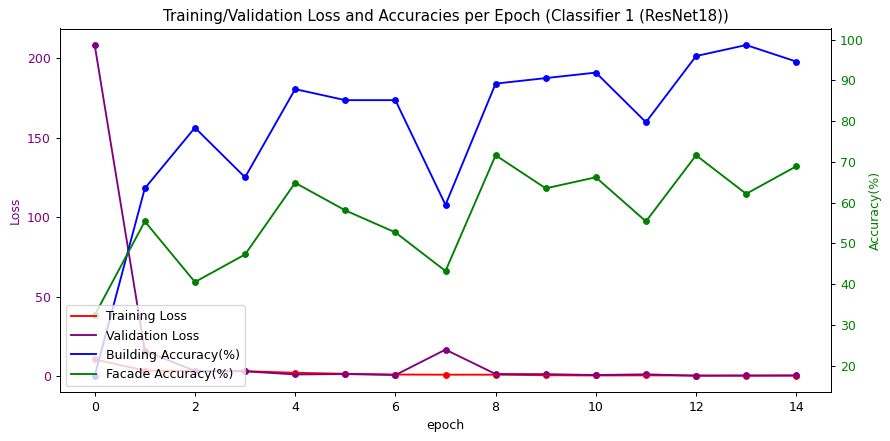

 --Validation Loss: 0.6662  --Building Accuracy: 94.59%  --Facade Accuracy: 68.92%


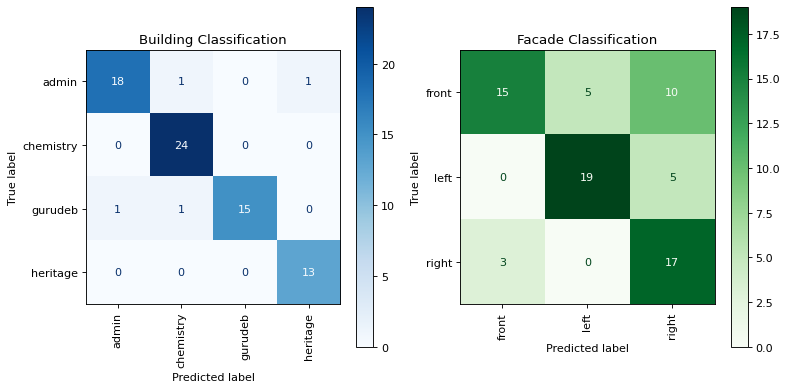

(94.5945945945946, 68.91891891891892, np.float64(0.6662125051021576))

In [ ]:
# plot results
plot_classifier_results(result1, "Classifier 1 (ResNet18)")
classifier1.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 2

In [ ]:
# Instance 2 with different parameters
model1 = reset_model(model1)  # NEEDED to clear previous run data
classifier2 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.Adam(model1.parameters(), lr=0.0001),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
# result2 = classifier2.train(n_epochs=10, output_logging=False)
result2 = classifier2.train(n_epochs=10, output_logging=True)

reset all
Starting training with Learning Rate: 0.0001, Batch Size: 32, Epochs: 10, Device: cuda----


 10%|█         | 1/10 [00:15<02:18, 15.35s/it]

 Training loss: 8.2414 --Validation Loss: 4.8568 --Building Accuracy: 43.24% --Facade Accuracy: 28.38%


 20%|██        | 2/10 [00:31<02:05, 15.69s/it]

 Training loss: 4.4921 --Validation Loss: 7.3339 --Building Accuracy: 45.95% --Facade Accuracy: 36.49%


 30%|███       | 3/10 [00:47<01:51, 15.91s/it]

 Training loss: 3.9210 --Validation Loss: 6.8364 --Building Accuracy: 54.05% --Facade Accuracy: 35.14%


 40%|████      | 4/10 [01:02<01:34, 15.73s/it]

 Training loss: 3.0831 --Validation Loss: 2.5195 --Building Accuracy: 85.14% --Facade Accuracy: 59.46%


 50%|█████     | 5/10 [01:18<01:18, 15.68s/it]

 Training loss: 2.4087 --Validation Loss: 2.3362 --Building Accuracy: 94.59% --Facade Accuracy: 64.86%


 60%|██████    | 6/10 [01:34<01:02, 15.63s/it]

 Training loss: 2.6174 --Validation Loss: 2.8575 --Building Accuracy: 93.24% --Facade Accuracy: 66.22%


 70%|███████   | 7/10 [01:49<00:46, 15.54s/it]

 Training loss: 2.0314 --Validation Loss: 1.6185 --Building Accuracy: 98.65% --Facade Accuracy: 64.86%


 80%|████████  | 8/10 [02:06<00:31, 15.88s/it]

 Training loss: 1.6606 --Validation Loss: 1.6246 --Building Accuracy: 91.89% --Facade Accuracy: 77.03%


 90%|█████████ | 9/10 [02:21<00:15, 15.74s/it]

 Training loss: 1.8326 --Validation Loss: 2.0812 --Building Accuracy: 94.59% --Facade Accuracy: 68.92%


100%|██████████| 10/10 [02:36<00:00, 15.68s/it]

 Training loss: 1.6366 --Validation Loss: 1.6342 --Building Accuracy: 90.54% --Facade Accuracy: 82.43%
Training done.....................


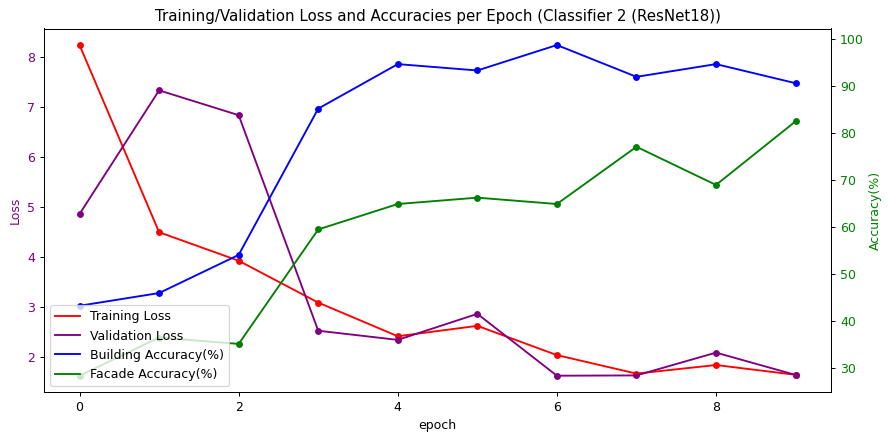

 --Validation Loss: 1.6342  --Building Accuracy: 90.54%  --Facade Accuracy: 82.43%


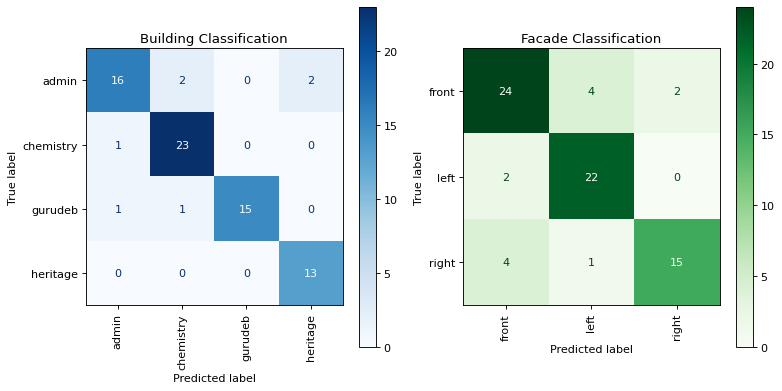

(90.54054054054053, 82.43243243243244, np.float64(1.634208122889201))

In [ ]:
# plot results
plot_classifier_results(result2, "Classifier 2 (ResNet18)")
classifier2.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 3

In [ ]:
# Instance 3 with different parameters
model1 = reset_model(model1)  # NEEDED to clear previous run data
classifier3 = BuildingWithFacadeClassifier(
    model=model1,
    optimizer=optim.SGD(model1.parameters(), lr=0.0005, momentum=0.9),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
result3 = classifier3.train(n_epochs=20, output_logging=False)
# result3 = classifier3.train(n_epochs=20, output_logging=True)

reset all
Starting training with Learning Rate: 0.0005, Batch Size: 32, Epochs: 20, Device: cuda----


100%|██████████| 20/20 [05:09<00:00, 15.45s/it]

Training done.....................


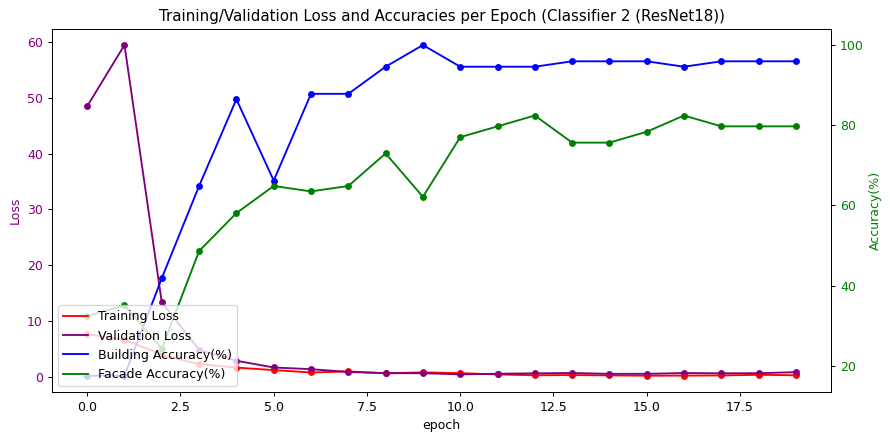

 --Validation Loss: 0.8600  --Building Accuracy: 95.95%  --Facade Accuracy: 79.73%


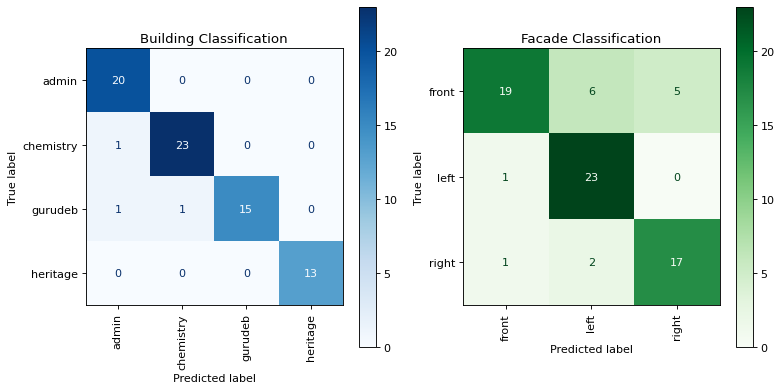

(95.94594594594594, 79.72972972972973, np.float64(0.8599943021933237))

In [ ]:
# plot results
plot_classifier_results(result3, "Classifier 2 (ResNet18)")
classifier3.evaluate(output_logging=True, disp_confusion_matrix=True)

In [ ]:
# add more to test

### model 2 ResNet Pretrained=True

In [ ]:
model2 = models.resnet18(weights="ResNet18_Weights.DEFAULT")  # pretrained = True
# Freeze all parameters in the feature extraction layers
# NEEDED when do Pretain with DEFAULT weights
for param in model2.parameters():
    param.requires_grad = False
model2 = modify_last_layer(model2, pretrained=True)
model2._is_pretrained_backbone


last layer output for model = 512 -> 256 -> convert to 4 and 3 outputs


True

#### Classifier 4

In [ ]:
# model 2 -> Instance 1 with different parameters

classifier4 = BuildingWithFacadeClassifier(
    model=model2, optimizer=optim.Adam(model1.parameters(), lr=0.0001), batch_size=16
)

# change output_logging=True to print output of each iteration
# result4 = classifier4.train(n_epochs=20, output_logging=False)
result4 = classifier4.train(n_epochs=20, output_logging=True)


Starting training with Learning Rate: 0.0001, Batch Size: 16, Epochs: 20, Device: cuda----


  5%|▌         | 1/20 [00:14<04:37, 14.61s/it]

 Training loss: 15.9910 --Validation Loss: 15.3590 --Building Accuracy: 36.49% --Facade Accuracy: 35.14%


 10%|█         | 2/20 [00:29<04:22, 14.59s/it]

 Training loss: 17.1561 --Validation Loss: 15.2838 --Building Accuracy: 36.49% --Facade Accuracy: 31.08%


 15%|█▌        | 3/20 [00:43<04:06, 14.52s/it]

 Training loss: 16.6482 --Validation Loss: 15.4604 --Building Accuracy: 33.78% --Facade Accuracy: 33.78%


 20%|██        | 4/20 [00:58<03:52, 14.53s/it]

 Training loss: 16.3628 --Validation Loss: 14.8885 --Building Accuracy: 33.78% --Facade Accuracy: 35.14%


 25%|██▌       | 5/20 [01:12<03:37, 14.51s/it]

 Training loss: 16.2830 --Validation Loss: 15.4557 --Building Accuracy: 35.14% --Facade Accuracy: 33.78%


 30%|███       | 6/20 [01:27<03:22, 14.48s/it]

 Training loss: 16.7417 --Validation Loss: 15.4656 --Building Accuracy: 37.84% --Facade Accuracy: 32.43%


 35%|███▌      | 7/20 [01:41<03:09, 14.55s/it]

 Training loss: 16.0131 --Validation Loss: 15.5785 --Building Accuracy: 36.49% --Facade Accuracy: 35.14%


 40%|████      | 8/20 [01:56<02:56, 14.70s/it]

 Training loss: 17.4346 --Validation Loss: 15.5762 --Building Accuracy: 37.84% --Facade Accuracy: 32.43%


 45%|████▌     | 9/20 [02:11<02:42, 14.76s/it]

 Training loss: 16.5816 --Validation Loss: 15.7021 --Building Accuracy: 37.84% --Facade Accuracy: 35.14%


 50%|█████     | 10/20 [02:26<02:27, 14.70s/it]

 Training loss: 17.1075 --Validation Loss: 15.0589 --Building Accuracy: 37.84% --Facade Accuracy: 33.78%


 55%|█████▌    | 11/20 [02:40<02:11, 14.62s/it]

 Training loss: 16.5230 --Validation Loss: 15.3881 --Building Accuracy: 36.49% --Facade Accuracy: 35.14%


 60%|██████    | 12/20 [02:55<01:56, 14.54s/it]

 Training loss: 16.7251 --Validation Loss: 15.4167 --Building Accuracy: 37.84% --Facade Accuracy: 33.78%


 65%|██████▌   | 13/20 [03:09<01:41, 14.50s/it]

 Training loss: 16.5358 --Validation Loss: 15.4020 --Building Accuracy: 37.84% --Facade Accuracy: 29.73%


 70%|███████   | 14/20 [03:23<01:26, 14.48s/it]

 Training loss: 16.5482 --Validation Loss: 15.3801 --Building Accuracy: 36.49% --Facade Accuracy: 33.78%


 75%|███████▌  | 15/20 [03:38<01:12, 14.51s/it]

 Training loss: 15.8942 --Validation Loss: 15.3662 --Building Accuracy: 37.84% --Facade Accuracy: 33.78%


 80%|████████  | 16/20 [03:52<00:57, 14.44s/it]

 Training loss: 16.2302 --Validation Loss: 15.3294 --Building Accuracy: 33.78% --Facade Accuracy: 35.14%


 85%|████████▌ | 17/20 [04:07<00:43, 14.42s/it]

 Training loss: 15.6718 --Validation Loss: 15.5451 --Building Accuracy: 36.49% --Facade Accuracy: 33.78%


 90%|█████████ | 18/20 [04:21<00:29, 14.52s/it]

 Training loss: 15.9785 --Validation Loss: 15.1504 --Building Accuracy: 39.19% --Facade Accuracy: 35.14%


 95%|█████████▌| 19/20 [04:36<00:14, 14.62s/it]

 Training loss: 16.9235 --Validation Loss: 15.2531 --Building Accuracy: 36.49% --Facade Accuracy: 32.43%


100%|██████████| 20/20 [04:51<00:00, 14.56s/it]

 Training loss: 16.0542 --Validation Loss: 15.6370 --Building Accuracy: 35.14% --Facade Accuracy: 36.49%
Training done.....................


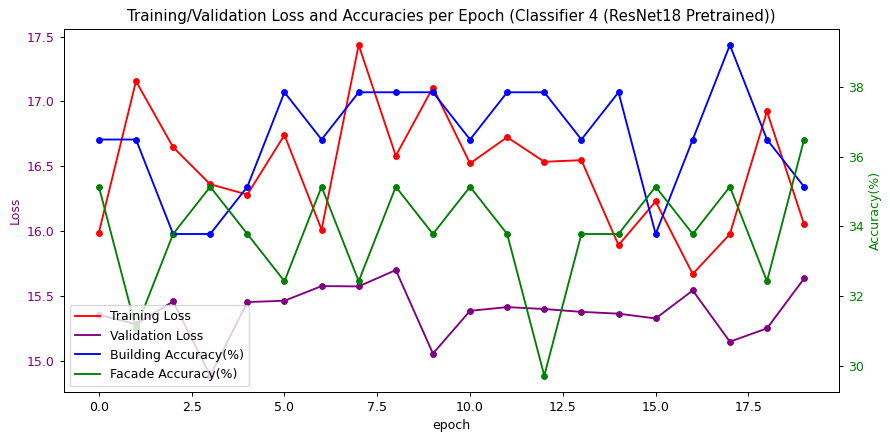

 --Validation Loss: 15.6370  --Building Accuracy: 35.14%  --Facade Accuracy: 36.49%


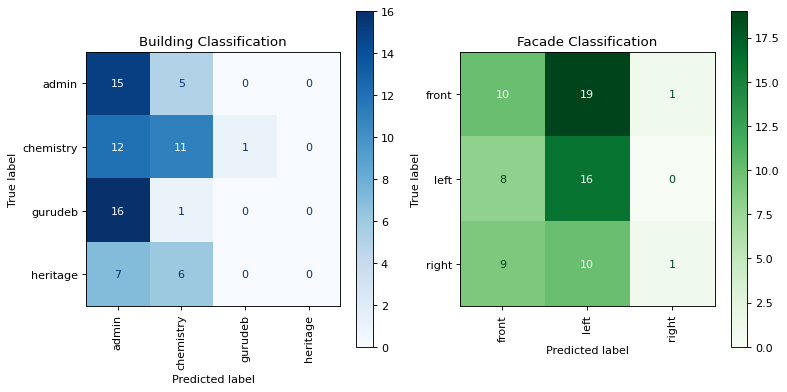

(35.13513513513514, 36.486486486486484, np.float64(15.637040901184083))

In [ ]:
# plot results
plot_classifier_results(result4, "Classifier 4 (ResNet18 Pretrained)")
classifier4.evaluate(output_logging=True, disp_confusion_matrix=True)

#### Classifier 5

In [ ]:
# model 2 -> Instance 2 with different parameters
model2 = reset_model(model2)  # NEEDED for clearing previous run data
classifier5 = BuildingWithFacadeClassifier(
    model=model2, optimizer=optim.Adam(model1.parameters(), lr=0.0001), batch_size=16
)

# change output_logging=True to print output of each iteration
# result5 = classifier5.train(n_epochs=5, output_logging=False)
result5 = classifier5.train(n_epochs=5, output_logging=True)


reset last
Starting training with Learning Rate: 0.0001, Batch Size: 16, Epochs: 5, Device: cuda----


 20%|██        | 1/5 [00:14<00:59, 14.89s/it]

 Training loss: 24.5278 --Validation Loss: 23.5570 --Building Accuracy: 28.38% --Facade Accuracy: 28.38%


 40%|████      | 2/5 [00:29<00:44, 14.74s/it]

 Training loss: 24.3081 --Validation Loss: 25.9297 --Building Accuracy: 29.73% --Facade Accuracy: 29.73%


 60%|██████    | 3/5 [00:43<00:29, 14.58s/it]

 Training loss: 24.5289 --Validation Loss: 25.4360 --Building Accuracy: 29.73% --Facade Accuracy: 32.43%


 80%|████████  | 4/5 [00:58<00:14, 14.57s/it]

 Training loss: 24.6269 --Validation Loss: 25.6699 --Building Accuracy: 29.73% --Facade Accuracy: 29.73%


100%|██████████| 5/5 [01:13<00:00, 14.61s/it]

 Training loss: 23.4684 --Validation Loss: 26.3492 --Building Accuracy: 29.73% --Facade Accuracy: 29.73%
Training done.....................


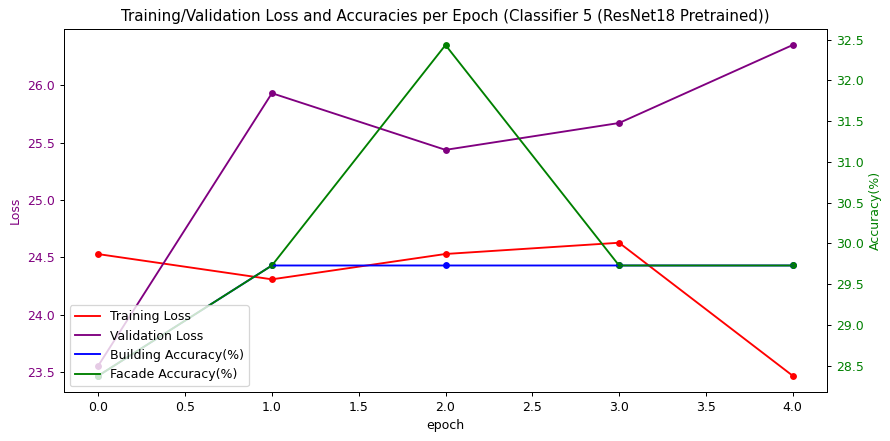

 --Validation Loss: 26.3492  --Building Accuracy: 29.73%  --Facade Accuracy: 29.73%


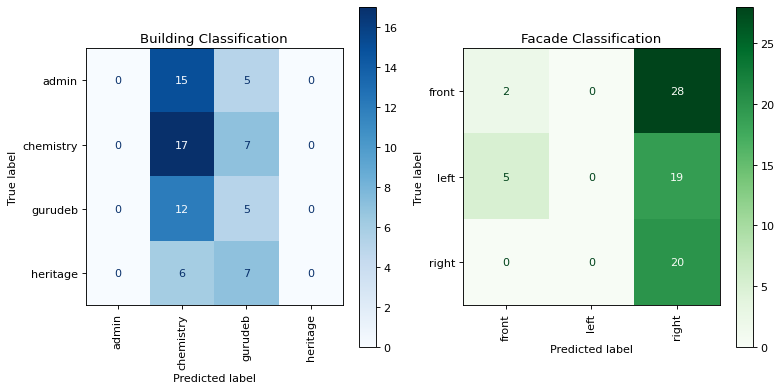

(29.72972972972973, 29.72972972972973, np.float64(26.349239349365234))

In [ ]:
# plot results
plot_classifier_results(result5, "Classifier 5 (ResNet18 Pretrained)")
classifier5.evaluate(output_logging=True, disp_confusion_matrix=True)


In [ ]:
# add more to test